In [ ]:
import json
import pandas as pd
from typing import Dict, List, Optional, Union
from pydantic import BaseModel, Field
from datasets import Dataset
from bespokelabs import curator
import argparse
from pathlib import Path
from typing import List, Dict
import litellm 
litellm.drop_params = True
import os
os.environ["AWS_PROFILE"] = "genai"
os.environ["CURATOR_VIEWER"] = "1"
os.environ["BESPOKE_API_KEY"] = "bespoke-9ff97e97445794907bec5ef8d57fd925da61e8ba7586c17ec2dca4bdffb87b9b"

#model_name = "bedrock/us.anthropic.claude-3-7-sonnet-20250219-v1:0"
#model_name = "bedrock/us.amazon.nova-micro-v1:0"  # Does not work
#model_name = "bedrock/us.amazon.nova-lite-v1:0" # Does not work 
#model_name = "bedrock/us.amazon.nova-pro-v1:0"
model_name = "bedrock/us.anthropic.claude-sonnet-4-20250514-v1:0" # Works with careful backend params

In [6]:
curator.LLM?

Init signature:
curator.LLM(
    model_name: str,
    response_format: Optional[Type[pydantic.main.BaseModel]] = None,
    batch: bool = False,
    backend: Optional[str] = None,
    generation_params: dict | None = None,
    backend_params: Union[bespokelabs.curator.request_processor.config.OnlineBackendParams, bespokelabs.curator.request_processor.config.BatchBackendParams, bespokelabs.curator.request_processor.config.OfflineBackendParams, NoneType] = None,
    system_prompt: str | None = None,
)
Docstring:      Interface for prompting LLMs.
Init docstring:
Initialize a LLM.

Args:
    model_name: The name of the LLM to use
    response_format: A Pydantic model specifying the
        response format from the LLM
    batch: Whether to use batch processing
    backend: The backend to use ("openai", "litellm", or "vllm"). If None, will be auto-determined
    generation_params: Additional parameters to pass to the generation API
    backend_params: Dictionary parameters for request proce

In [7]:
# ============================================================================
# Pydantic Models for Structured Outputs
# ============================================================================

class MolecularProperty(BaseModel):
    """Molecular property prediction with confidence and reasoning."""
    property_name: str = Field(description="Name of the molecular property")
    predicted_value: float = Field(description="Predicted numerical value")
    confidence: str = Field(description="Confidence level: high, medium, low")
    reasoning: str = Field(description="Chemical reasoning for the prediction")
    key_structural_features: List[str] = Field(description="Important structural features affecting the property")


In [8]:
# ============================================================================
# Core Dataset Generators
# ============================================================================
class PropertyPredictor(curator.LLM):
    """Generates property prediction tasks with reasoning."""
    
    response_format = MolecularProperty
    
    def prompt(self, input: Dict) -> str:
        smiles = input['canonical_smiles']
        property_type = input.get('standard_type', 'LogD')

        return f"""You are an expert medicinal chemistry research assistant. You have knowledge in areas including:

- Drug design and development - structure-activity relationships (SAR), lead optimization, pharmacophore modeling
- Synthetic chemistry - reaction mechanisms, synthetic routes, protecting group strategies
- Pharmacology - drug-target interactions, pharmacokinetics (ADME), pharmacodynamics
- Computational chemistry - molecular modeling, QSAR and ADME predictions
- Analytical techniques - NMR, MS, HPLC and other characterization methods
- Medicinal chemistry strategies - bioisosteres, prodrugs, fragment-based drug design

Analyze the following molecule and predict its {property_type}.

Molecule (SMILES): {smiles}

Provide a detailed prediction including:
1. The predicted {property_type} value
2. Your confidence level
3. Chemical reasoning based on structural features
4. Key structural features that influence this property

Consider factors like:
- Lipophilicity and hydrophilicity
- Molecular weight and size
- Functional groups present
- Aromatic systems
- Hydrogen bonding potential
- Charge distribution"""

    def parse(self, input: Dict, response: MolecularProperty) -> Dict:
        return {
            "smiles": input['canonical_smiles'],
            "actual_value": input.get('standard_value'),
            "predicted_value": response.predicted_value,
            "property_type": input.get('standard_type', 'LogD'),
            "confidence": response.confidence,
            "reasoning": response.reasoning,
            "key_features": response.key_structural_features,
        }

In [9]:
df = pd.read_csv('/Users/ldodda/Documents/Codes/GraphGen/test_logd.csv')

## Sampling from all bins of LogD Data to make sure I am getting a diverse set

In [10]:
# Create bins for logd values covering the full range -8 to +8
import numpy as np

# Create 16 bins from -8 to +8
bins = np.linspace(-8, 8, 17)  # 17 edges create 16 bins
df['logd_bin'] = pd.cut(df['logd'], bins=bins, include_lowest=True)

# Sample from each bin (e.g., 20 samples per bin)
samples_per_bin = 100
sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(
    lambda x: x.sample(min(len(x), samples_per_bin), random_state=42)
)

print(f"Original dataset size: {len(df)}")
print(f"Sampled dataset size: {len(sampled_df)}")
print("\nSamples per bin:")
print(sampled_df['logd_bin'].value_counts().sort_index())
print(f"\nBin width: {(8 - (-8))/16} = 1.0 LogD unit per bin")

Original dataset size: 9999
Sampled dataset size: 1075

Samples per bin:
logd_bin
(-8.001, -7.0]      2
(-7.0, -6.0]        4
(-6.0, -5.0]        4
(-5.0, -4.0]       12
(-4.0, -3.0]       38
(-3.0, -2.0]       68
(-2.0, -1.0]      100
(-1.0, 0.0]       100
(0.0, 1.0]        100
(1.0, 2.0]        100
(2.0, 3.0]        100
(3.0, 4.0]        100
(4.0, 5.0]        100
(5.0, 6.0]        100
(6.0, 7.0]        100
(7.0, 8.0]         47
Name: count, dtype: int64

Bin width: 1.0 = 1.0 LogD unit per bin


/var/folders/2d/s6tm3wj949lf8cdhpv06q97r0000gr/T/ipykernel_62578/2257146822.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('logd_bin', observed=False, group_keys=False).apply(


In [11]:
sampled_df.drop(columns=['logd_bin'], inplace=True)

In [12]:
sampled_df

,smiles,logd
5046,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810
2726,NC(Cc1ccc(O)cc1)C(=O)O,-7.260
1794,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070
2746,CN(C)C(N)=NC(=N)N,-6.130
453,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350
...,...,...
993,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120
7280,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612
1702,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040
4508,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280


In [13]:
sampled_df.columns = ['canonical_smiles', 'standard_value']
sampled_df['standard_type'] = 'LogD'

In [14]:
mol_data_dict = sampled_df.to_dict(orient='records')

In [15]:
logd_dataset = Dataset.from_list(mol_data_dict)

In [16]:
logd_dataset

Dataset({
    features: ['canonical_smiles', 'standard_value', 'standard_type'],
    num_rows: 1075
})

In [22]:
# Solution 1: Add timeout and retry configuration
import time

# Configure the predictor with timeout and retry settings
predictor = PropertyPredictor(
    model_name=model_name,
    backend="litellm",
    backend_params={
        "max_requests_per_minute": 180,        # 10% buffer under 200 RPM limit
        "seconds_to_pause_on_rate_limit": 60   # Wait 1 minute on rate limit
    }
)

[11/03/25 11:15:14] INFO     Getting rate limits for model:                 ]8;id=390795;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py\litellm_online_request_processor.py]8;;\:]8;id=288433;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py#213\213]8;;\
                             bedrock/us.anthropic.claude-sonnet-4-20250514-                                        
                             v1:0                                                                                  

[11/03/25 11:15:16] INFO     Test call headers: {}                          ]8;id=879755;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py\litellm_online_request_processor.py]8;;\:]8;id=938830;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/litellm_online_request_processor.py#199\199]8;;\

In [23]:
print("Generating predictions...")
results = predictor(logd_dataset)


Generating predictions...


[11/03/25 11:15:23] INFO     Authenticated with Curator API key                                        ]8;id=329759;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py\client.py]8;;\:]8;id=308797;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py#42\42]8;;\

                    INFO     Running LiteLLMOnlineRequestProcessor completions with   ]8;id=546041;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=110757;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#133\133]8;;\
                             model:                                                                                
                             bedrock/us.anthropic.claude-sonnet-4-20250514-v1:0                                    

                    INFO     Using cached requests. If you want to regenerate the     ]8;id=28210;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=314962;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#214\214]8;;\
                             dataset, disable or delete the cache.                                                 
                              See                                                                                  
                             https://docs.bespokelabs.ai/bespoke-curator/tutorials/au                              
                             tomatic-recovery-and-caching#disable-caching for more                                 
                             information.                                                                          

                    INFO     Manually set max_requests_per_minute to 180       ]8;id=861857;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=139344;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#191\191]8;;\

                    WARNING  No manual max_tokens_per_minute set, and headers  ]8;id=652063;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=309875;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#216\216]8;;\
                             based detection failed, using default value of                                        
                             100000                                                                                

                    INFO     Resuming progress by reading existing file:              ]8;id=200842;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=351979;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#579\579]8;;\
                             /Users/ldodda/.cache/curator/56fb17923d582c8f/responses_                              
                             0.jsonl                                                                               

                    INFO     Found 842 successful requests and 0 previously failed    ]8;id=402274;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=982559;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#598\598]8;;\
                             requests and 0 parsing errors in                                                      
                             /Users/ldodda/.cache/curator/56fb17923d582c8f/responses_                              
                             0.jsonl                                                                               

/Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[11/03/25 11:15:42] WARNING  Encountered 'InstructorRetryException:            ]8;id=949714;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=465496;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=999565;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=715502;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=815890;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=817692;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:15:43] WARNING  Encountered 'InstructorRetryException:            ]8;id=396770;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=817586;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=910385;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=922955;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:15:44] WARNING  Encountered 'InstructorRetryException:            ]8;id=928794;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=407788;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=949261;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=661797;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:15:45] WARNING  Encountered 'InstructorRetryException:            ]8;id=525791;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=469064;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=853383;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=671301;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:15:46] WARNING  Encountered 'InstructorRetryException:            ]8;id=439329;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=22747;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=46402;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=909959;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

[11/03/25 11:15:47] WARNING  Encountered 'InstructorRetryException:            ]8;id=672068;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=148652;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=189662;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=959403;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=130718;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=961026;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=198115;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=414378;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=967077;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=366990;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=815193;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=420128;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=951498;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=244242;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=789361;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=872667;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=234853;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=774638;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=305900;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=435780;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=908922;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=548174;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=143916;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=301290;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=151460;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=682244;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=274697;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=144678;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=746799;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=57205;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=84329;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=772064;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=122064;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=588161;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=431981;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=290224;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=717120;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=452827;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=623491;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=154276;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=834668;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=168461;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=604790;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=274158;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:16:21] WARNING  Encountered 'InstructorRetryException:            ]8;id=876596;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=566695;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:17:39] WARNING  Encountered 'InstructorRetryException:            ]8;id=33662;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=361305;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

[11/03/25 11:17:58] WARNING  Encountered 'InstructorRetryException:            ]8;id=801403;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=475617;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:00] WARNING  Encountered 'InstructorRetryException:            ]8;id=946763;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=211165;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:16] WARNING  Encountered 'InstructorRetryException:            ]8;id=300103;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=525195;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=434275;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=669337;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=561848;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=878295;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=198130;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=54682;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=790785;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=978973;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=303070;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=842852;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=830598;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=756605;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=208686;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=96591;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

[11/03/25 11:18:17] WARNING  Encountered 'InstructorRetryException:            ]8;id=270494;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=677629;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=394904;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=241328;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=401094;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=720640;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:18] WARNING  Encountered 'InstructorRetryException:            ]8;id=85767;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=713256;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completio

[11/03/25 11:18:19] WARNING  Encountered 'InstructorRetryException:            ]8;id=696702;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=290863;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=926017;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=350266;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=348443;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=715115;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:20] WARNING  Encountered 'InstructorRetryException:            ]8;id=131134;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=434845;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=113348;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=839405;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:32] WARNING  Encountered 'InstructorRetryException:            ]8;id=775204;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=292896;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=558913;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=566124;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

[11/03/25 11:18:33] WARNING  Encountered 'InstructorRetryException:            ]8;id=605415;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=704631;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

                    WARNING  Encountered 'InstructorRetryException:            ]8;id=609494;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=508477;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#533\533]8;;\
                             <failed_attempts>                                                                     
                                                                                                                   
                             <generation number="1">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="2">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completion>                                                                          
                                 None                                                                              
                             </completion>                                                                         
                             </generation>                                                                         
                                                                                                                   
                             <generation number="3">                                                               
                             <exception>                                                                           
                                 litellm.RateLimitError: BedrockException -                                        
                             {"message":"Too many tokens, please wait before                                       
                             trying again."}                                                                       
                             </exception>                                                                          
                             <completi

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • Time Elapsed 0:03:29 • Time Remaining 0:00:00

Curator Viewer: ]8;id=144264;https://curator.bespokelabs.ai/datasets/d601faac3c2e40c6b3a4bf9ec8971aa4\✨ Open Curator Viewer]8;;\ ✨                                                                          
https://curator.bespokelabs.ai/datasets/d601faac3c2e40c6b3a4bf9ec8971aa4                                           
Requests: Total: 1075 • Cached: 842✓ • Success: 233✓ • Failed: 0✗ • In Progress: 0⋯ • Req/min: 66.9 • Res/min: 66.9
Tokens: Avg Input: 851 • Input TPM: 56879 • Avg Output: 418 • Output TPM: 27974                                    
Cost: Current: $0.000 • Est. Total: $0.000 ($0.000 remaining) • Rate: $0.000/min                                   
Rate Limits: RPM: 180 • TPM: 100000 • TPM Strategy: combined token limit                                           
Model: Name: bedrock/us.anthropic.claude-sonnet-4-20250514-v1:0                                                    
Model Pricing: Per 1M tokens: Input: N/A • Output: N/A

                             Final Curator Statistics                              
╭────────────────────────────┬────────────────────────────────────────────────────╮
│ Section/Metric             │ Value                                              │
├────────────────────────────┼────────────────────────────────────────────────────┤
│ Model                      │                                                    │
│ Name                       │ bedrock/us.anthropic.claude-sonnet-4-20250514-v1:0 │
│ Rate Limit (RPM)           │ 180                                                │
│ Rate Limit (TPM)           │ 100000                                             │
│ Requests                   │                                                    │
│ Total Processed            │ 233                                                │
│ Successful                 │ 233                                                │
│ Failed                     │ 0                                                  │
│ Tokens                     │                                                    │
│ Total Tokens Used          │ 295,712                                            │
│ Total Input Tokens         │ 198,222                                            │
│ Total Output Tokens        │ 97,490                                             │
│ Average Tokens per Request │ 1269                                               │
│ Average Input Tokens       │ 850                                                │
│ Average Output Tokens      │ 418                                                │
│ Costs                      │                                                    │
│ Total Cost                 │ $0.000                                             │
│ Average Cost per Request   │ $0.000                                             │
│ Input Cost per 1M Tokens   │ N/A                                                │
│ Output Cost per 1M Tokens  │ N/A                                                │
│ Performance                │                                                    │
│ Total Time                 │ 209.12s                                            │
│ Average Time per Request   │ 0.90s                                              │
│ Requests per Minute        │ 66.9                                               │
│ Responses per Minute       │ 66.9                                               │
│ Max Concurrent Requests    │ 54                                                 │
│ Input Tokens per Minute    │ 56873.9                                            │
│ Output Tokens per Minute   │ 27971.9                                            │
╰────────────────────────────┴────────────────────────────────────────────────────╯

[11/03/25 11:18:53] INFO     Processing complete. Results saved to             ]8;id=168544;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=967310;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#459\459]8;;\
                             /Users/ldodda/.cache/curator/56fb17923d582c8f/res                                     
                             ponses_0.jsonl                                                                        

                    INFO     Status tracker: Tasks - Started: 233, In          ]8;id=947124;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py\base_online_request_processor.py]8;;\:]8;id=903918;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/online/base_online_request_processor.py#460\460]8;;\
                             Progress: 0, Succeeded: 233, Failed: 0, Already                                       
                             Completed: 842                                                                        
                             Errors - API: 0, Rate Limit: 0, Other: 58, Total:                                     
                             58                                                                                    

                    INFO     Read 1075 responses.                                     ]8;id=824184;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=299086;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#444\444]8;;\

                    INFO     Finalizing writer                                        ]8;id=225416;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=132731;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#453\453]8;;\

                    INFO     Creating a file with all failed requests                 ]8;id=820001;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=778754;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#462\462]8;;\

                    INFO     Created file with failed requests at                     ]8;id=654368;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py\base_request_processor.py]8;;\:]8;id=555012;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/request_processor/base_request_processor.py#490\490]8;;\
                             /Users/ldodda/.cache/curator/56fb17923d582c8f/failed_req                              
                             uests.jsonl                                                                           

                    WARNING  There was a previous run with the same run hash (56fb17923d582c8f) without  ]8;id=926787;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/llm/llm.py\llm.py]8;;\:]8;id=148910;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/llm/llm.py#294\294]8;;\
                             the CURATOR_VIEWER flag enabled, and CURATOR_VIEWER flag is enabled for               
                             this run. This means that the Curator Viewer is potentially inconsistent              
                             with local data.Pushing the full dataset to the Curator Viewer to ensure              
                             full consistency.                                                                     

                    INFO     Authenticated with Curator API key                                        ]8;id=968005;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py\client.py]8;;\:]8;id=88539;file:///Users/ldodda/Documents/Codes/GraphGen/.venv/lib/python3.10/site-packages/bespokelabs/curator/client.py#42\42]8;;\

Curator Viewer: ]8;id=732002;https://curator.bespokelabs.ai/datasets/d601faac3c2e40c6b3a4bf9ec8971aa4\✨ Open Curator Viewer]8;;\ ✨
https://curator.bespokelabs.ai/datasets/d601faac3c2e40c6b3a4bf9ec8971aa4

In [24]:
print("\n📊 Results:")
logD_dataset_df = results.dataset.to_pandas()


📊 Results:


In [25]:
fname_suffix = f'logD_predictions_w_{model_name.split("/")[1]}'

In [26]:
fname_suffix

'logD_predictions_w_us.anthropic.claude-sonnet-4-20250514-v1:0'

In [27]:
logD_dataset_df.to_csv(fname_suffix +'.csv')
logD_dataset_df

,smiles,actual_value,predicted_value,property_type,confidence,reasoning,key_features
0,CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1,-7.810,-3.5,LogD,high,This molecule contains a bisphosphonate core w...,[Bisphosphonate group with multiple ionizable ...
1,NC(Cc1ccc(O)cc1)C(=O)O,-7.260,-2.8,LogD,high,"This molecule is L-tyrosine, a naturally occur...","[Zwitterionic amino acid structure, Carboxylic..."
2,CC(C)CCCC(C)CCn1cc[n+](CC(P(=O)([O-])O)P(=O)(O...,-6.070,-3.2,LogD,high,This molecule contains a bisphosphonate core s...,[Bisphosphonate group with two phosphonic acid...
3,CN(C)C(N)=NC(=N)N,-6.130,-2.5,LogD,high,"This molecule is metformin, a well-known antid...","[Multiple nitrogen atoms with lone pairs, Guan..."
4,O=P(O)(O)C(CNc1nccs1)P(=O)(O)O,-6.350,-4.2,LogD,high,This molecule contains a geminal diphosphonic ...,"[Two phosphonic acid groups, Primary amine, Th..."
...,...,...,...,...,...,...,...
1070,N#Cc1nc(-c2ccccc2)oc1S(=O)(=O)c1ccc(Cl)cc1,7.120,3.2,LogD,medium,The molecule contains both lipophilic and hydr...,"[Sulfonyl group (electron-withdrawing, polar),..."
1071,COc1ccc(CNc2nc(NCCOC(=O)CCCCCCCCc3cn(CCC(=O)N[...,7.612,3.2,LogD,medium,"This is a large, complex molecule with signifi...","[Multiple methoxy groups (6 total), Triazine c..."
1072,CC(C)Oc1ccc(-c2nnc(-c3ccnn3C)s2)cc1Cl,7.040,4.2,LogD,medium,This molecule exhibits high lipophilicity due ...,"[Isopropyl ether group, Chlorinated aromatic r..."
1073,COC(=O)c1cc(OC(=O)c2ccc(OC)c(O)c2)c(OC)cc1CCN1...,7.280,2.8,LogD,medium,This molecule presents a complex balance of li...,[Two aromatic rings with electron-donating met...


In [28]:
results.dataset

Dataset({
    features: ['smiles', 'actual_value', 'predicted_value', 'property_type', 'confidence', 'reasoning', 'key_features'],
    num_rows: 1075
})

In [29]:
results.dataset.to_list()

[{'smiles': 'CC(C)CCOc1ccc[n+](CC(P(=O)([O-])O)P(=O)(O)O)c1',
  'actual_value': -7.81,
  'predicted_value': -3.5,
  'property_type': 'LogD',
  'confidence': 'high',
  'reasoning': 'This molecule contains a bisphosphonate core with two phosphonic acid groups attached to a quaternary pyridinium ring via an alkyl linker, and an isobutoxy substituent on the pyridine ring. The LogD prediction is dominated by several highly polar features: (1) The bisphosphonate moiety contains multiple ionizable phosphate groups that will be largely deprotonated at physiological pH (pKa values typically 1-7 for phosphonic acids), contributing significant negative charge and hydrophilicity. (2) The quaternary pyridinium nitrogen carries a permanent positive charge, making this a zwitterionic molecule at physiological pH. (3) The combination of multiple phosphate oxygens creates extensive hydrogen bonding potential with water. (4) While the isobutoxy group (CC(C)CCO-) provides some lipophilic character, it is

In [30]:
output_file = fname_suffix + ".jsonl"
with open(output_file, 'w') as f:
    for item in results.dataset.to_list():
        f.write(json.dumps(item) + '\n')

In [31]:
"""
Data Preparation Script for Llama 3.2 3B Fine-tuning
Converts bespokelabs-curator dataset to instruction-following format
"""

system_prompt = """You are an expert medicinal chemistry research assistant. You have knowledge in areas including:

- Drug design and development - structure-activity relationships (SAR), lead optimization, pharmacophore modeling
- Synthetic chemistry - reaction mechanisms, synthetic routes, protecting group strategies
- Pharmacology - drug-target interactions, pharmacokinetics (ADME), pharmacodynamics
- Computational chemistry - molecular modeling, QSAR and predicting ADME properties
- Analytical techniques - NMR, MS, HPLC and other characterization methods
- Medicinal chemistry strategies - bioisosteres, prodrugs, fragment-based drug design

You analyze molecular structures using SMILES notation and provide accurate predictions for LogD values (distribution coefficient at pH 7.4). 
Your predictions are based on careful analysis of structural features, lipophilic and hydrophilic contributions, and established cheminformatics principles.
"""
class DatasetConverter:
    """Convert molecular property dataset to instruction-following format."""
    
    def __init__(self, input_path: str, output_path: str):
        self.input_path = Path(input_path)
        self.output_path = Path(output_path)
        
        if not self.input_path.exists():
            raise FileNotFoundError(f"Input file not found: {input_path}")
    
    def convert_to_instruction_format(self) -> None:
        """Convert dataset to Llama 3.2 instruction format."""
        
        print(f"Reading dataset from: {self.input_path}")
        
        with open(self.input_path, 'r') as f_in:
            with open(self.output_path, 'w') as f_out:
                example_count = 0
                
                for line_num, line in enumerate(f_in, 1):
                    try:
                        example = json.loads(line)
                        converted = self._create_instruction_example(example)
                        f_out.write(json.dumps(converted) + '\n')
                        example_count += 1
                        
                    except json.JSONDecodeError as e:
                        print(f"Warning: Invalid JSON on line {line_num}: {e}")
                    except KeyError as e:
                        print(f"Warning: Missing field on line {line_num}: {e}")
        
        print(f"✓ Converted {example_count} examples")
        print(f"✓ Output saved to: {self.output_path}")
    
    @staticmethod
    def _create_instruction_example(entry: Dict) -> Dict:
        """
        Convert single entry to instruction format.
        
        Args:
            entry: Original entry with SMILES, values, and reasoning
            
        Returns:
            Dictionary with 'text' field containing formatted conversation
        """
        
        smiles = entry['smiles']
        actual_value = entry['actual_value']
        reasoning = entry['reasoning']
        key_features = ', '.join(entry['key_features'])
        
        # Create the full conversation in Llama 3.2 format
        text = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
{system_prompt}
<|eot_id|><|start_header_id|>user<|end_header_id|>
Analyze the following molecule and predict its LogD value.

SMILES: {smiles}

Key Structural Features: {key_features}

Chemical Analysis and Reasoning:
{reasoning}

Based on this analysis, what is the predicted LogD value for this molecule?
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
Based on the detailed structural analysis, considering the balance of lipophilic and hydrophilic features:

The predicted LogD value is: **{actual_value}**

This prediction reflects:
- The lipophilic contributions from the {key_features.split(',')[0] if ',' in key_features else 'aromatic and aliphatic components'}
- The hydrophilic contributions from polar functional groups
<|eot_id|>"""
        
        return {"text": text}
    
    def validate_output(self) -> bool:
        """Validate the converted dataset."""
        
        print("\nValidating dataset...")
        
        try:
            examples = []
            with open(self.output_path, 'r') as f:
                for i, line in enumerate(f):
                    ex = json.loads(line)
                    if 'text' not in ex:
                        raise ValueError(f"Line {i}: missing 'text' field")
                    examples.append(ex)
            
            print(f"✓ Valid JSONL format")
            print(f"✓ Number of examples: {len(examples)}")
            
            # Show statistics
            text_lengths = [len(ex['text']) for ex in examples]
            print(f"✓ Average text length: {sum(text_lengths) / len(text_lengths):.0f} chars")
            print(f"✓ Min length: {min(text_lengths)} chars")
            print(f"✓ Max length: {max(text_lengths)} chars")
            
            # Show sample
            print(f"\n--- Sample Example (first 500 chars) ---")
            print(examples[0]['text'][:500] + "...\n")
            
            return True
            
        except Exception as e:
            print(f"✗ Validation failed: {e}")
            return False

In [32]:
converter = DatasetConverter(f'./{fname_suffix}.jsonl', f'./{fname_suffix}_formatted.jsonl')
converter.convert_to_instruction_format()

Reading dataset from: logD_predictions_w_us.anthropic.claude-sonnet-4-20250514-v1:0.jsonl
✓ Converted 1075 examples
✓ Output saved to: logD_predictions_w_us.anthropic.claude-sonnet-4-20250514-v1:0_formatted.jsonl


In [33]:
from datasets import Dataset


def load_jsonl_data(file_path):
    """Load JSONL dataset."""
    texts = []
    with open(file_path, 'r') as f:
        for line in f:
            example = json.loads(line)
            texts.append(example['text'])
    return texts

DATASET_PATH = './logd_formatted.jsonl'
print(f"Loading dataset from {DATASET_PATH}...")
texts = load_jsonl_data(DATASET_PATH)
print(f"Loaded {len(texts)} examples")

# Create HF dataset
dataset = Dataset.from_dict({
    'text': texts
})

Loading dataset from ./logd_formatted.jsonl...
Loaded 1075 examples


In [34]:
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 860
    })
    test: Dataset({
        features: ['text'],
        num_rows: 215
    })
})

📊 LogD Prediction Performance Metrics:
Mean Squared Error (MSE):     5.2920
Root Mean Squared Error (RMSE): 2.3004
Mean Absolute Error (MAE):    1.7973
R² Score:                     0.4840
Pearson Correlation:          0.7046
Spearman Correlation:         0.7574
Spearman p-value:             7.05e-201


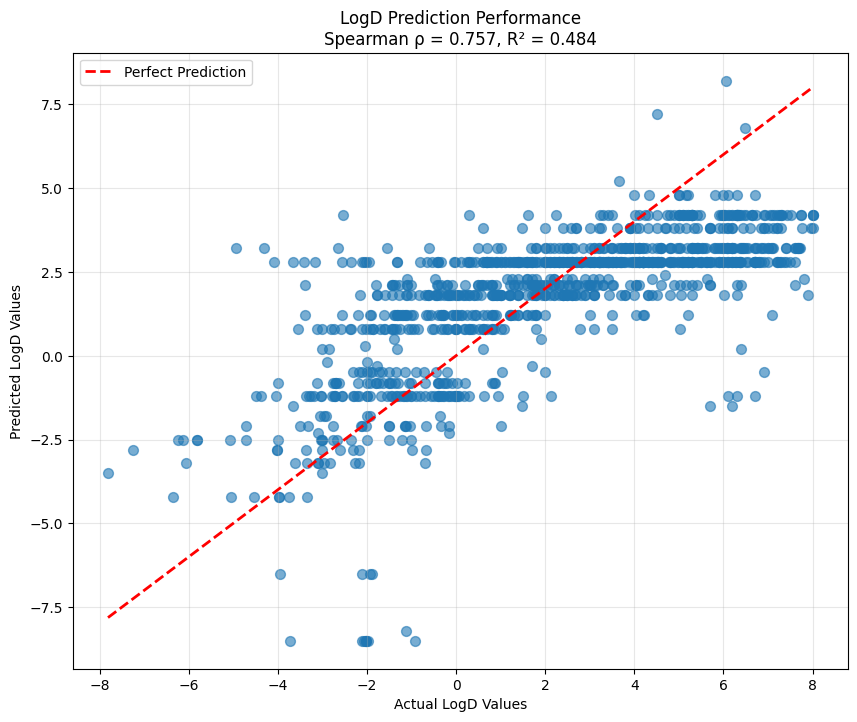

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

import matplotlib.pyplot as plt

# Calculate regression metrics
actual_values = logD_dataset_df['actual_value']
predicted_values = logD_dataset_df['predicted_value']

# Regression metrics
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Spearman correlation
spearman_corr, spearman_p = spearmanr(actual_values, predicted_values)

# Pearson correlation (for comparison)
pearson_corr = actual_values.corr(predicted_values)

print("📊 LogD Prediction Performance Metrics:")
print("=" * 50)
print(f"Mean Squared Error (MSE):     {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):    {mae:.4f}")
print(f"R² Score:                     {r2:.4f}")
print(f"Pearson Correlation:          {pearson_corr:.4f}")
print(f"Spearman Correlation:         {spearman_corr:.4f}")
print(f"Spearman p-value:             {spearman_p:.2e}")

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(actual_values, predicted_values, alpha=0.6, s=50)
plt.plot([actual_values.min(), actual_values.max()], 
         [actual_values.min(), actual_values.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual LogD Values')
plt.ylabel('Predicted LogD Values')
plt.title(f'LogD Prediction Performance\nSpearman ρ = {spearman_corr:.3f}, R² = {r2:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'{fname_suffix}_regression_performance.png', dpi=300)
plt.show()

📊 LogD Zone Classification Performance:
Overall Accuracy: 0.6623

Classification Report:
                  precision    recall  f1-score   support

       High (>4)       0.89      0.24      0.37       347
       Low (<-2)       0.71      0.45      0.55       121
Medium (-2 to 4)       0.64      0.95      0.76       607

        accuracy                           0.66      1075
       macro avg       0.74      0.55      0.56      1075
    weighted avg       0.73      0.66      0.61      1075



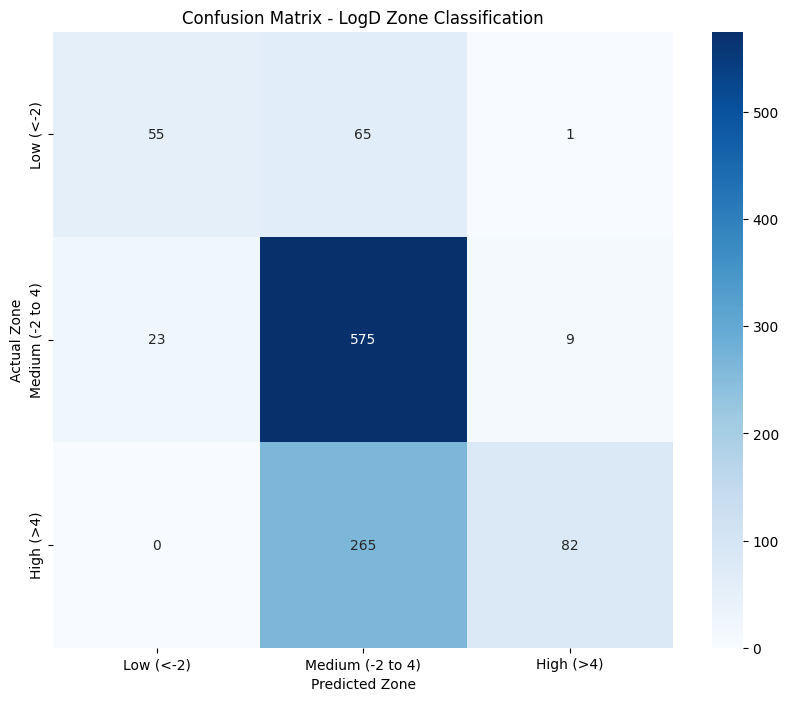


📈 Zone Distribution:
Actual zones:
actual_zone
High (>4)           347
Low (<-2)           121
Medium (-2 to 4)    607
Name: count, dtype: int64

Predicted zones:
predicted_zone
High (>4)            92
Low (<-2)            78
Medium (-2 to 4)    905
Name: count, dtype: int64


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Create LogD zones classification
def classify_logd(value):
    if value < -2:
        return 'Low (<-2)'
    elif value <= 4:
        return 'Medium (-2 to 4)'
    else:
        return 'High (>4)'

# Apply classification to actual and predicted values
logD_dataset_df['actual_zone'] = actual_values.apply(classify_logd)
logD_dataset_df['predicted_zone'] = predicted_values.apply(classify_logd)

# Generate classification statistics

# Calculate classification metrics
accuracy = accuracy_score(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone'])

print("📊 LogD Zone Classification Performance:")
print("=" * 60)
print(f"Overall Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone']))

# Create confusion matrix
cm = confusion_matrix(logD_dataset_df['actual_zone'], logD_dataset_df['predicted_zone'], 
                     labels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'])

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'],
            yticklabels=['Low (<-2)', 'Medium (-2 to 4)', 'High (>4)'])
plt.title('Confusion Matrix - LogD Zone Classification')
plt.xlabel('Predicted Zone')
plt.ylabel('Actual Zone')
plt.savefig(f'{fname_suffix}_confusion_matrix.png', dpi=300)
plt.show()

# Show distribution of zones
print("\n📈 Zone Distribution:")
print("Actual zones:")
print(logD_dataset_df['actual_zone'].value_counts().sort_index())
print("\nPredicted zones:")
print(logD_dataset_df['predicted_zone'].value_counts().sort_index())

In [38]:
#dataset.push_to_hub("lsdodda/LogD-Predictor")